```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: ca2502127969ef8eb828499ac582af6fc10a2747 on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler gpu_ctx

Path to the test file

In [5]:
source_url = "..\\..\\..\\..\\havvarsel-data\\test_polstere.nc"
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [6]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

## Generating GPUOcean Simulation from Input

In [7]:
dimY, dimX = ds.h.data.shape
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [8]:
t=5*24 + 11 # INPUT

In [9]:
y_cut = 145

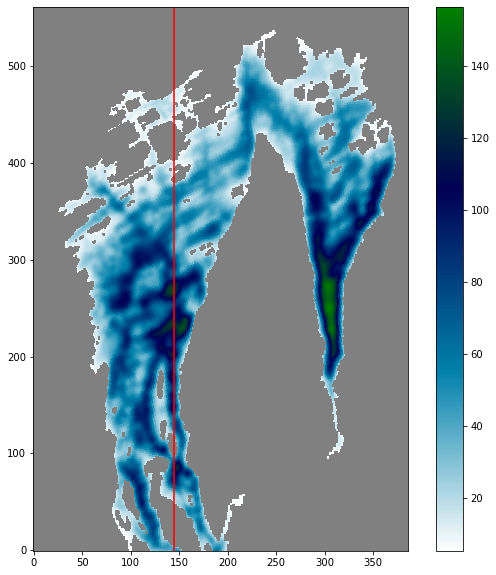

In [10]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][y0:y1,x0:x1], mask=1-nc["mask_rho"][y0:y1,x0:x1])

cmap_H = copy.copy(plt.cm.ocean_r)
cmap_H.set_bad(alpha=0.5)

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(H_m, cmap=cmap_H, origin="lower")
ax.axvline(x=y_cut, c="red")

plt.colorbar(im)

In [11]:
u = 0.5*(nc["u"][t,:,y0:y1,x0:x1]+nc["u"][t,:,y0:y1,x0+1:x1+1])
v = 0.5*(nc["v"][t,:,y0:y1,x0:x1]+nc["v"][t,:,y0+1:y1+1,x0:x1])

In [12]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)

s_nc = Dataset(source_url)
s_hs   = s_nc["h"][y0:y1,x0:x1]
s_rhos = s_nc["Cs_r"][:]

depth_show_meters = 25 # upper layer thickness for plotting in meters

depth_show_resolution = 4 # discretisation levels per meter

s_pot_densities_show = np.ma.array(np.zeros((s_pot_densities.shape[1],depth_show_meters*depth_show_resolution)))
s_pot_densities_show[:,0] =  s_pot_densities[-1][:,y_cut]
for depth_level in range(1,depth_show_resolution*depth_show_meters):
    depth = depth_level/depth_show_resolution

    integrator_low = NetCDFInitialization.MLD_integrator(source_url, np.ma.array(depth*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
    dens_low = np.sum(integrator_low * s_pot_densities, axis=0)
    if depth_level == 1:
        dens_up = 0.0
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        mask_next_level = copy.copy(s_pot_densities_show[:,depth_level]<1000)
    else:
        integrator_up = NetCDFInitialization.MLD_integrator(source_url, np.ma.array((depth-1/depth_show_resolution)*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
        dens_up  = np.sum(integrator_up * s_pot_densities, axis=0)
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        s_pot_densities_show[:,depth_level].mask = copy.copy(mask_next_level)
        if depth > 5:
            mask_next_level = np.all((integrator_low[1:,:,y_cut] == integrator_up[1:,:,y_cut]), axis=0)

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd_r"))
  after removing the cwd from sys.path.


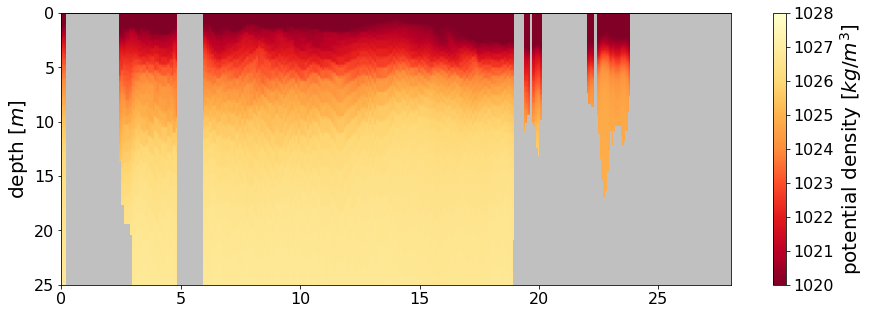

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap_dens = plt.cm.YlOrRd_r
cmap_dens.set_bad(alpha=0.25)

extent = [0, s_pot_densities_show.shape[0]*50/1000, depth_show_meters, 0]

im = ax.imshow(s_pot_densities_show.T, 
                origin="upper", cmap=cmap_dens, 
                aspect='auto', extent=extent, 
                vmin=1020, vmax=1028)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("depth [$m$]", fontsize=20)

cb = plt.colorbar(im, pad=0.05)
cb.set_label(label="potential density [$kg/m^3$]", size=20)
cb.ax.tick_params(labelsize=16)



In [14]:
mlds = []
mld_values = [1021.0, 1021.5, 1022.0, 1022.5, 1023.0, 1023.5, 1024.0, 1024.5, 1025.0, 1025.5, 1026.0]
for mld_value in mld_values:
    mlds.append(np.minimum(NetCDFInitialization.MLD(source_url, mld_value, min_mld=1.5, max_mld=40, x0=x0, x1=x1, y0=y0, y1=y1, t=t), H_m))

In [15]:
import matplotlib.lines as mlines

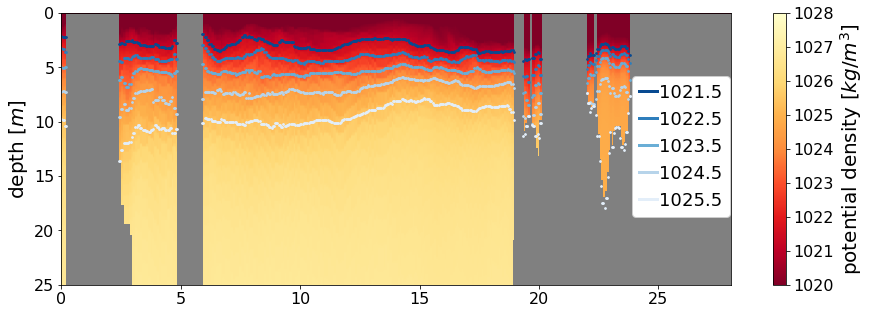

In [26]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap_dens = copy.copy(plt.cm.YlOrRd_r)
cmap_dens.set_bad("grey",alpha=1.0)

extent = [0, s_pot_densities_show.shape[0]*50/1000, depth_show_meters, 0]

im = ax.imshow(s_pot_densities_show.T, 
                origin="upper", cmap=cmap_dens, 
                aspect='auto', extent=extent, 
                vmin=1020, vmax=1028)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("depth [$m$]", fontsize=20)

cb = plt.colorbar(im, pad=0.05)
cb.set_label(label="potential density [$kg/m^3$]", size=20)
cb.ax.tick_params(labelsize=16)

cmap=plt.cm.Blues

ms = [1, 3, 5, 7, 9]
legend_handles = [] 
for m in range(len(ms)):
    ax.scatter(np.arange(s_pot_densities.shape[1])*50/1000, mlds[ms[m]][:,y_cut], s=3, color=cmap(1-ms[m]/10))#, alpha=(1-ms[m]/10))
    legend_handles.append(mlines.Line2D([], [], c=cmap(1-ms[m]/10), lw=3, label=str(mld_values[ms[m]])))

plt.legend(handles=legend_handles, handlelength=1, loc=(0.8525, 0.25), 
        handletextpad=0.1, 
        facecolor="white", framealpha=1,
        labelcolor="black", fontsize=18)

plt.savefig("figs/mlds.pdf")